#  Proyecto IOT : José Javier Gutiérrez Gil

# 0. Librererias necesarias

In [ ]:
%matplotlib inline 
from matplotlib import pyplot as plt

import json
import time
import random
import logging
import datetime
import platform
import threading
from paho import mqtt
from time import sleep
import multiprocessing
from threading import Thread
from time import perf_counter
import paho.mqtt.client as paho
from IPython.display import clear_output
from scipy.spatial import distance as dist
from imutils.video import FileVideoStream
from imutils.video import VideoStream
from pynq.lib.video import *
from imutils import face_utils
import multiprocessing
import numpy as np  
import argparse
import platform
import imutils
import dlib
import cv2
import os

# 1. Creación ficheros de log

In [ ]:
# Definición del logger root
# -----------------------------------------------------------------------------
logging.basicConfig(
    format = '%(asctime)-5s %(name)-15s %(levelname)-8s %(message)s',
    level  = logging.INFO,
    filemode = "a"
    )
# Nuevos handlers
# -----------------------------------------------------------------------------
# Si el root logger ya tiene handlers, se eliminan antes de añadir los nuevos.
# Esto es importante para que los logs no empiezen a duplicarse.
if logging.getLogger('').hasHandlers():
    logging.getLogger('').handlers.clear()
    
# Se añaden tres nuevos handlers al root logger, uno para los niveles de debug o
# superiores, otro recogida de datos y otro para que se muestre por pantalla los niveles de info o
# superiores.
#---------------Recogida de datos de eventos---------------------

log_data= f"logs_data_pynq_{datetime.datetime.now().strftime('%Y%m%d.log')}"
file_data_handler = logging.FileHandler(log_data)
 
file_data_handler.setLevel(logging.CRITICAL)
file_data_format = logging.Formatter('%(asctime)-5s %(name)-15s %(levelname)-8s %(message)s')
file_data_handler.setFormatter(file_data_format)
logging.getLogger('').addHandler(file_data_handler)

#-------------------Trazas de Debug del prototipo -----------------

log_debg = f"logs_debug_{datetime.datetime.now().strftime('%Y%m%d_test.log')}"
file_debug_handler = logging.FileHandler(log_debg)
#file_debug_handler .TimedRotatingFileHandler(filename = log_debg,  when='s', interval=1, backupCount=5)
 
file_debug_handler.setLevel(logging.DEBUG)
file_debug_format = logging.Formatter('%(asctime)-5s %(name)-15s %(levelname)-8s %(message)s')
file_debug_handler.setFormatter(file_debug_format)
logging.getLogger('').addHandler(file_debug_handler)

#----------------Trazas de infor para desarrollo---------------------

consola_handler = logging.StreamHandler()
consola_handler.setLevel(logging.INFO)
consola_handler_format = logging.Formatter('%(asctime)-5s %(name)-15s %(levelname)-8s %(message)s')
consola_handler.setFormatter(consola_handler_format)
logging.getLogger('').addHandler(consola_handler) 

# 2. Funciones Comunicación MQTT (HiveMQ)

In [ ]:
#--------------------------------------------------------------
# Definición Constantes y Mensajes Intercambio HiveMQtt e UART/Bluetooth
#----------------------------------------------------------------
HOST_HIVEMQ   = "dbd25372b1b647e895c3f4adb0260f4e.s2.eu.hivemq.cloud" 
PORT_HIVEMQ   = 8883
clean_session = True

client_id     = "Client_00"
server_id     = "Client_01"
client_cam_id = "Client_02"

user_name     = "adasjg01"
password      = "adas2022_01"

user_name2     = "adasjg01"
password2      = "adasjg02_iot02"

user_name_cam     = "adasjg_cam"
password_cam      = "adas2022_cam"

topic_sub_pynq       = "ADASJG01/Pynq/#" # De esta forma leo los mensajes de intercambio y los eento de la cam
topic_pub_pynq       = "ADASJG01/Server"
topic_pub_client_cam = "ADASJG01/Server/cam"


## 2.1 Publicador eventos cam 

Nota: Implementado cuando la obtención de eventos de somnolencia se realiza mediante PYNQ. Misma implementación que se tiene en el modulo iotadas.py que se utiliza en PC. En este caso se modifica el topic, al topic que lee el proceso subscritor en el PC.

In [ ]:
# MQTT: client_cam
client_cam = None
send_cam_scr = threading.Semaphore()  # Para publicar mesajes mediante diferentes hilos en exclusión y con sección critica (la publicación)

# MQTT
#--------------------------------------------------------
# Publicador eventos CAM
#------------------------------------------------------------
# Desarrollo multithreading, aparecen secciones criticas en los 
# adaptadores, publicadores y zonas compartidas. Mejora la respuesta 
# con el proceso y análisis de vídeo. Permite tener hilos dedicados 
# a cada tipo de comunicación (mqtt,uart, etc...)
 

def on_connect_client_cam (client, userdata, flags, rc, properties=None):
    if rc == 0:
        client.connected_flag = True
        logging.debug ("CLient_Cam::>>> Connected OK")
        return
    logging.debug ("CLient_Cam::>>> Failed to connect")

    
# with this callback you can see if your publish was successful
#def on_publish_client_cam (client, userdata, mid, properties=None):
    #print("CLient_Cam ::>>> mid: " + str(mid))
    
def connect_client_cam ():
    
    """
    Conecta topic 'ADASJG01/Pynq/cam'
    aunque con implementar una función de conexión sobraría (pasando como parametro el client_id)
    vamos a implementar dos funciones por separado para identificar claramente los dos clientes 
    que se tienen sobre el mismo broker mqtt
    """
    logging.info("connect_client_cam")
    # using MQTT version 5 here, for 3.1.1: MQTTv311, 3.1: MQTTv31
    # userdata is user defined data of any type, updated by user_data_set()
    # client_id is the given name of the client
    client = paho.Client (client_id=client_cam_id, userdata=None, protocol=paho.MQTTv5)
    client.on_connect = on_connect_client_cam
    # enable TLS for secure connection
    client.tls_set (tls_version=mqtt.client.ssl.PROTOCOL_TLS)
    # set username and password
    client.username_pw_set (user_name_cam, password_cam)
    # connect to HiveMQ Cloud on port 8883 (default for MQTT)
    logging.info(f'Conexión Cliente_cam : HOST{HOST_HIVEMQ}-port{PORT_HIVEMQ}')
    client.connect (HOST_HIVEMQ, PORT_HIVEMQ, keepalive = 60)
    client.connected_flag = False
    while not client.connected_flag: #wait in loop
        client.loop()#client_cam.loop_start()
        sleep (1)
        logging.debug ("NO CONECTA")
    return client

def disconnect_client_cam():
    send_cam_scr.acquire()
    logging.info("disconnect_client_cam")
    if 'client_cam' in globals():
        client_cam.unsubscribe(topic_pub_client_cam)
        client_cam.connected_flag = False
        client_cam.disconnect  ()
        
        #client_cam.loop_stop ()
        
        send_cam_scr.release()
#------------
# send_cloud_cam_mseg (topic,msg_out): Envia los eventos de parpadeo/bostezo/Somnolencia a la pynq
# Realement eenvia las accciones que debe realiar ante dichas situaciones.
# Al igual que con la función de conexión. Vamos a crear dos funciones de publicación por cliente (hilo)
# realmente con una sóla implementación sobraría (pasas como parametro la instancia de tu cliente)
#---------------
def send_cloud_cam_mseg (msg_out):
    send_cam_scr.acquire()
  
    #Sección crítica, par aevitar problemas de multithreding a la hora de enviar notficaciones
    #por eventos de somnolencia
    logging.debug("send_cloud_cam_mseg")
    topic = topic_pub_client_cam # Debería ser por fichero de configuración
    logging.debug(topic)
    logging.debug(msg_out)

    if msg_out is not None and len (msg_out) > 0:
        for i in range(0,len(msg_out)):
            msg = msg_out [i]
            logging.debug(msg)
            client_cam.publish (topic, payload = msg, qos=0)
    send_cam_scr.release()

In [ ]:
client_cam = connect_client_cam ()

## 2.2 Subscritor  de la APP PYNQ y Publicador eventos de distracción conductor

In [ ]:
client_hivemqtt = None
send_src     = threading.Semaphore()  # Para compartir publicador con los hilos que publican cada evento

#####################
# Cliente recive eventos placa Pynq y envia a servidor cada evento detectado por lso sensores
# Recive al acción a realizar del servidor y efectua la acción con los actuadores necesarios a dicha acción
#####################

# setting callbacks for different events to see if it works, print the message etc.
def on_connect_pynq (client, userdata, flags, rc, properties=None):
    if rc == 0:
        client.connected_flag = True
        logging.debug (" Cliente PYNQ:::>>> Connected OK")
        return
    logging.debug (" Cliente PYNQ:::>>> Failed to connect to %s, error was, rc=%s" % rc)
    
# with this callback you can see if your publish was successful
def on_publish_pynq (client, userdata, mid, properties=None):
    print(" Cliente PYNQ:::>>> mid: " + str(mid))

# print which topic was subscribed to
def on_subscribe_pynq  (client, userdata, mid, granted_qos, properties=None):
    print(" Cliente PYNQ:::>>> Subscribed: " + str(mid) + " " + str(granted_qos))
    
# print message, useful cfor checking if it was successful
 
def on_message_pynq (client, userdata, msg):

    logging.info(f' Cliente PYNQ:::>>> Thread {threading.get_ident()} - Processing on_message')
    logging.info(" Cliente PYNQ:::>>> Message received %s from topic %s" % (msg.topic, str(msg.payload.decode("utf-8"))) )
  
    str_msg = str(msg.payload.decode("utf-8"))
 
    if str_msg is not None:
        event = recv_evet_msg_json (str_msg)
        if event  == EVENT_LOGIN:
            logging.info ('EVENT_LOGIN')
            status    = recv_login_msg_json (str_msg)
            logging.info (status)
            if status == "OK":
                led_rgb (4,2)
            else:
                led_rgb (4,4)
        elif (get_color_led_rgb (4) ==  2 ) and event  == EVENT_LED_STICK:
            logging.info ('EVENT_LED_STICK')
            color = recv_params_msg_json (str_msg)
            led_stick (int(color[0]))
        elif (get_color_led_rgb (4) ==  2 ) and event  == EVENT_BUZZER:
            logging.info ('EVENT_BUZZER')
            paramms = recv_params_msg_json (str_msg)
            
            note    = paramms [0]
            beats   = [int(x) for x in paramms [1].split(sep=',')] #paramms [1]
            tempo   = int (paramms [2])
            count   = int (paramms [3])
            
            n = count
            
            for i in range(0,n):
                buzzer (note,beats,tempo)
  
        elif (get_color_led_rgb (4) ==  2 ) and event  == EVENT_SERVO:
            logging.info ('EVENT_SERVO')
            angle = recv_params_msg_json (str_msg)
            servo (int(angle[0]))
        elif (get_color_led_rgb (4) ==  2 ) and event  == EVENT_DTLIGTH:
            logging.info ('EVENT_DTLIGTH') 
            inten = recv_intensity_msg_json (str_msg)
            logging.info (f'Se ha detectado un aluz interna con una intensidad de {inten}') 
            logging.info (f'Recuerde que por llevar luces internas encendidas le pueden multar con 200 euros.') 
        elif (get_color_led_rgb (4) ==  2 ) and event  == EVENT_DTTEMP:
            logging.info ('EVENT_DTTEMP')
            temp = recv_temp_msg_json (str_msg)
            logging.info (f'Se ha detectado una temperatura de {temp}ºC')   
        else:
            logging.info('error')
    else:
        logging.info ("Cliente PYNQ:::>>> NOT str_msg")
        
def subscribing_pynq    (client,topic):
    logging.info ( f'Cliente PYNQ:::>>>  subscribing_pynq {topic}')
    client.on_message   = on_message_pynq
    client.on_subscribe = on_subscribe_pynq  
    client.subscribe (topic, qos=0)
    client.loop_forever()    
def main_pynq (client,topic,msg):
    # a single publish, this can also be done in loops, etc.
    client.publish (topic, payload = msg, qos=0)
        
# setting callbacks, use separate functions like above for better visibility
#client.on_subscribe = on_subscribe
#client.on_message   = on_message
#client.on_publish   = on_publish

# subscribe to all topics of encyclopedia by using the wildcard "#"
#client.subscribe(topic, qos=1)

# a single publish, this can also be done in loops, etc.
#client.publish(topic, payload="hot", qos=1)

# loop_forever for simplicity, here you need to stop the loop manually
# you can also use loop_start and loop_stop

#client.on_message   = on_message
#client.on_subscribe = on_subscribe
#client.subscribe(topic, qos=0)

def disconnect_hivemqtt():
    logging.debug("disconnect_hivemqtt ()")
    send_src.acquire()
    if 'client_hivemqtt' in globals() or 'client_hivemqtt' in locals():
        
        client_hivemqtt.unsubscribe (topic_sub_pynq)
        client_hivemqtt.connected_flag = False
        client_hivemqtt.disconnect ()
        #client_hivemqtt.loop_stop ()
    send_src.release()   

def isConnect_hivemqtt ():
    logging.debug("isConnect_hivemqtt ()")
  
    if 'client_hivemqtt' in globals() or 'client_hivemqtt' in locals():
        return client_hivemqtt.connected_flag 
    else:
        return False

def app_connect_hivemqtt_run ():
    logging.info("def app_connect_hivemqtt_run ():")
    #disconnect_hivemqtt()
    global client
    # using MQTT version 5 here, for 3.1.1: MQTTv311, 3.1: MQTTv31
    # userdata is user defined data of any type, updated by user_data_set()
    # client_id is the given name of the client
    client = paho.Client(client_id=client_id, userdata=None, protocol=paho.MQTTv5)
    client.on_connect = on_connect_pynq 
    # enable TLS for secure connection
    client.tls_set(tls_version=mqtt.client.ssl.PROTOCOL_TLS)
    # set username and password
    client.username_pw_set(user_name, password)
    # connect to HiveMQ Cloud on port 8883 (default for MQTT)
    client.connect (HOST_HIVEMQ, PORT_HIVEMQ, keepalive = 60)
    client.connected_flag = False
    while not client.connected_flag: #wait in loop
        client.loop  ()
        logging.info ("NO CONECTA")
        sleep (1)
    logging.info ("CONECTA")   
    return client 
        
def send_cloudmseg (topic,msg_out):
    send_src.acquire()
    logging.debug("send_cloudmseg")
    logging.debug(msg_out)
    if msg_out is not None and len (msg_out) > 0:
        for i in range(0,len(msg_out)):
            msg = msg_out [i]
            logging.debug(msg)
            sleep(1)
            client_hivemqtt.publish (topic, payload = msg, qos=0) # Para reducir la SC utilizams el objeto global
    send_src.release()    

In [ ]:
client_hivemqtt = app_connect_hivemqtt_run ()

## 2.3 Mensajes trasnmitidos entre script pynq y script PC

In [8]:

MSG_DTC_JSON           = '{"clientid":"AGASDJG01","action":"DTC","event":"None"}'

MSG_LOGIN              = '{"clientid":"AGASDJG01","action":"DTC","event":"LOGIN","status":"OK"}'

MDG_RTC_JSON_BUZZER    =  '{"clientid":"AGASDJG01","action":"RTC", \
                             "event":"BUZZER","paramms":["a,b,c,d,e,f,g,A",\
                                                         "1, 1, 1, 1, 1, 1, 2, 1",\
                                                          "10","3"]}'
MDG_RTC_JSON_SERVO     =  '{"clientid":"AGASDJG01","action":"RTC", \
                             "event":"SERVO","paramms":["180"]}'

MDG_RTC_JSON_LED_STICK =  '{"clientid":"AGASDJG01","action":"RTC", \
                             "event":"LED_STICK","paramms":["0xFF00FF"]}' 

MSG_DTC_TEMP = '{"clientid":"AGASDJG01","action":"DTC","event":"DTTEMP","Temp":"23"}'
MSG_RTC_TEMP = '{"clientid":"AGASDJG01","action":"RTC","event":"DTTEMP","Temp":"23"}'

MSG_DTC_LIGHT_INT = '{"clientid":"AGASDJG01","action":"DTC","event":"DTLIGTH","ILight":"23.2"}'
MSG_RTC_LIGHT_INT = '{"clientid":"AGASDJG01","action":"RTC","event":"DTLIGTH","ILight":"23.2"}'

"""
'DROWSINESS'  - detección de somnolencia (cam)
'DTBLINK'     - detección parpadeo (cam)
'DTYAWN'      - detección bostezo  (cam)
'DTSMOKING'   - detección fumando  (cam)
'DTDRINK'     - detección bebiendo (cam)
'DTEATING'    - detección comiendo (cam)
'DTMOBL'      - detección movil    (cam)
'DTLIGTH'     - detección de luz interna  (sensor intensidad de luz)
'DTTEMP'      - detección temperatura     (sensor temperatura interna)
'DANGPOS'     - no se detecta a cara del conductor, bien por taparse o posición inadecuada
--------
'BUZZER'    - Creación sonido alarma
'LED_STICK' - Señalizacion mediante testigos de luz
'SERVO'     - Movimiento SERVO, simulando conducción autónoma
"""

EVENT_NFTR      = "NFTR"    # Sin implementar
EVENT_DANGPOS   = "DANGPOS"   

EVENT_LOGIN     = "LOGIN"
#-- sensor Cam
EVENT_DANGPOS    = "DANGPOS" 
EVENT_DROWSINESS = 'DROWSINESS'
EVENT_DTBLINK    = "DTBLINK"
EVENT_DTYAWN     = "DTYAWN"
EVENT_DTSMOKING  = "DTSMOKING"
EVENT_DTDRINK    = "DTDRINK"
EVENT_DTEATING   = "DTEATING"
EVENT_DTMOBIL    = 'DTMOBIL'
#-- Sensor Temp
EVENT_DTTEMP     = "DTTEMP"
#-- Sensor Intensidad de Luz
EVENT_DTLIGTH    = "DTLIGTH"
 
#--- Actuadores

EVENT_BUZZER    = "BUZZER"
EVENT_LED_STICK = "LED_STICK"
EVENT_SERVO     = "SERVO" 

In [9]:
import json

def msg_dangpos (status,clientid='Client_01'):
    msg = json.loads(MSG_DTC_JSON)
    msg ['event'] = EVENT_DANGPOS
    msg ['clientid'] = clientid
    
    return json.dumps(msg)

def msg_login (status,clientid='Client_01'):
    msg = json.loads(MSG_LOGIN)
    msg ['clientid'] = clientid
    msg ['event'] = EVENT_LOGIN
    msg ['status'] = status
 
    return json.dumps(msg)

def msg_buzzer (note,beats,tempo,count,clientid='Client_01'):
    msg = json.loads(MDG_RTC_JSON_BUZZER)
    msg ['clientid'] = clientid
    msg ['event'] = EVENT_BUZZER
    msg['paramms'][0] = note
    msg['paramms'][1] = beats
    msg['paramms'][2] = tempo
    msg['paramms'][3] = count
    
    return json.dumps(msg)

def msg_servo (angle,clientid='Client_01'):  
    msg = json.loads(MDG_RTC_JSON_SERVO)
    msg ['clientid'] = clientid
    msg ['event'] = EVENT_SERVO
    msg['paramms'][0] = angle
    
    return json.dumps(msg)

def msg_led_stick (color,clientid='Client_01'):   
    msg = json.loads(MDG_RTC_JSON_LED_STICK)
    msg ['clientid'] = clientid
    msg ['event'] = EVENT_LED_STICK
    msg['paramms'][0] = color
    
    return json.dumps(msg)

def send_msg_json (action='DTC',event=None,vparam=None,clientid='Client_01'):
    msg = None
    if vparam == None:
        msg = json.loads(MSG_DTC_JSON)
        msg ['event'] = event
    else:
        if event == EVENT_DTTEMP:
            msg = json.loads(MSG_DTC_TEMP)
            msg ['event'] = event  
            msg ['Temp']  = vparam
        elif event == EVENT_DTLIGTH:
            msg = json.loads(MSG_RTC_LIGHT_INT)
            msg ['event']  = event  
            msg ['ILight'] = vparam
        else:
            msg = json.loads(MSG_DTC_JSON)
            msg ['event'] = event
            
    if msg is not None:
        msg ['action']   = action 
        msg ['clientid'] = clientid
    json_temp = json.dumps(msg)
    
    return json_temp

def recv_evet_msg_json (msg):
    logging.debug ('recv_evet_msg_json')
    logging.debug (msg)
    str_msg = msg #str(msg.payload.decode("utf-8"))
    
    event = None
    if str_msg is not None and str_msg != '':
        msg_in  = json.loads(str_msg) #decode json data
        event = msg_in["event"]
        logging.info(event)
    else:
        logging.debug("NOT str_msg")

    return event

def recv_login_msg_json (msg):
    logging.debug('recv_login_msg_json')
    logging.debug(msg)
 
    str_msg = msg #str(msg.payload.decode("utf-8"))
    
    status = None
    if str_msg is not None:
        msg_in  = json.loads(str_msg) #decode json data
        status = msg_in["status"]
    else:
        logging.debug ("NOT str_msg")

    return status

def recv_intensity_msg_json (msg):
    logging.debug('recv_intensity_msg_json')
    logging.debug(msg)
    str_msg = msg #str(msg.payload.decode("utf-8"))
    
    paramms = None
    if str_msg is not None:
        msg_in  = json.loads(str_msg) #decode json data
        ILight = msg_in["ILight"]
        logging.debug(ILight) 
    else:
        logging.debug("NOT str_msg")

    return ILight

def recv_temp_msg_json (msg):
    logging.info('recv_temp_msg_json')
    logging.debug(msg)
    str_msg = msg #str(msg.payload.decode("utf-8"))
    
    paramms = None
    if str_msg is not None:
        msg_in  = json.loads(str_msg) #decode json data
        Temp = msg_in["Temp"]
    else:
        logging.debug ("NOT str_msg")

    return Temp

def recv_params_msg_json (msg):
    logging.info('recv_params_msg_json')
    logging.debug(msg)
    str_msg = msg #str(msg.payload.decode("utf-8"))
    
    paramms = None
    if str_msg is not None:
        msg_in  = json.loads(str_msg) #decode json data
        paramms = msg_in["paramms"]
    else:
        logging.debug ("NOT str_msg")

    return paramms 


### 2.0 Test funciones mensajes

In [10]:
print(send_msg_json (event=EVENT_DROWSINESS))
print(send_msg_json (event=EVENT_DTBLINK))
print(send_msg_json (event=EVENT_DTYAWN))
print(send_msg_json (event=EVENT_DANGPOS))
print(send_msg_json (event=EVENT_NFTR))
print(send_msg_json (event=EVENT_DTTEMP,vparam=23))
print(send_msg_json (event=EVENT_DTLIGTH,vparam=23))

print("")

recv_evet_msg_json (msg_buzzer("a,b,c,d,e,f,g,A","1, 1, 1, 1, 1, 1, 2, 1","10","2"))
recv_params_msg_json (msg_buzzer("a,b,c,d,e,f,g,A","1, 1, 1, 1, 1, 1, 2, 1","10","3"))

recv_evet_msg_json (msg_servo (90))
recv_params_msg_json (msg_servo (90))
 
recv_evet_msg_json (msg_led_stick (0xFF00FF))
recv_params_msg_json (msg_led_stick (0xFF00FF))
 
recv_evet_msg_json (send_msg_json ('RTC',EVENT_DTTEMP,23 ))
recv_temp_msg_json (send_msg_json ('RTC',EVENT_DTTEMP,23 ))
recv_evet_msg_json (send_msg_json ('RTC',EVENT_DTLIGTH,23.2))
recv_intensity_msg_json (send_msg_json ('RTC',EVENT_DTLIGTH,23.2))

2023-01-06 22:59:25,096 root            INFO     BUZZER
2023-01-06 22:59:25,110 root            INFO     recv_params_msg_json
2023-01-06 22:59:25,117 root            INFO     SERVO
2023-01-06 22:59:25,124 root            INFO     recv_params_msg_json
2023-01-06 22:59:25,131 root            INFO     LED_STICK
2023-01-06 22:59:25,139 root            INFO     recv_params_msg_json
2023-01-06 22:59:25,147 root            INFO     DTTEMP
2023-01-06 22:59:25,154 root            INFO     recv_temp_msg_json
2023-01-06 22:59:25,162 root            INFO     DTLIGTH


{"clientid": "Client_01", "action": "DTC", "event": "DROWSINESS"}
{"clientid": "Client_01", "action": "DTC", "event": "DTBLINK"}
{"clientid": "Client_01", "action": "DTC", "event": "DTYAWN"}
{"clientid": "Client_01", "action": "DTC", "event": "DANGPOS"}
{"clientid": "Client_01", "action": "DTC", "event": "NFTR"}
{"clientid": "Client_01", "action": "DTC", "event": "DTTEMP", "Temp": 23}
{"clientid": "Client_01", "action": "DTC", "event": "DTLIGTH", "ILight": 23}



23.2

# 3. Acceso overlay base y Adaptadores

In [11]:
from pynq.overlays.base import BaseOverlay
 
base = BaseOverlay("base.bit")

In [12]:
from pynq_peripherals import ArduinoSEEEDGroveAdapter, PmodGroveAdapter

 

adapter  = ArduinoSEEEDGroveAdapter(base.ARDUINO, A3 = 'grove_light', 
                                    A1 = 'grove_temperature',
                                    D3 = 'grove_buzzer',
                                    D5 = 'grove_servo', 
                                    D7 = 'grove_led_stick')
 
ligth       = adapter.A3
servo       = adapter.D5
buzzer      = adapter.D3
led_stick   = adapter.D7
temp_sensor = adapter.A1

In [13]:
print('temperature: {:.2f}'.format(adapter.A1.get_temperature()))

temperature: 17.37


## 3.1 Acceso sensores y adaptadores en exclusión (Sección crítica al tener app multithreading)

In [14]:
# Secciones criticas, cuando modificacmos de forma asincrona actuadores

servo_scr     = threading.Semaphore()  #  
buzzer_src    = threading.Semaphore()  #  
led_stick_scr = threading.Semaphore()  #  
leds_rgb_scr  = threading.Semaphore()  #  
temp_scr      = threading.Semaphore()  # 
intent_scr    = threading.Semaphore()  # 
## SENSORES
def temp_sensor ():
    logging.info(' temp_sensor ( )')
    return round(adapter.A1.get_temperature(),2) #adapter.A1.get_temperature()-25

def ligth_intensity ():
    logging.info('ligth_intensity ( )')
    return adapter.A3.get_intensity()

## ACTUADORES
def get_color_led_rgb (iled):
     return base.rgbleds [iled].read ()
    
def led_rgb (iled,color):
    leds_rgb_scr.acquire()
    base.rgbleds [iled].write (color)
    leds_rgb_scr.release()
    
def led_stick (color):
    led_stick_scr.acquire()
    adapter.D7.clear()
 
    for i in range(10):
        adapter.D7.set_pixel(i, color)
    adapter.D7.show()
    led_stick_scr.release()
    
def clean_led_stick ():
    led_stick_scr.acquire()
    adapter.D7.clear()
    led_stick_scr.release()
        
def buzzer (note,beats,tempo):
    buzzer_src.acquire()

    adapter.D3.play_tone(262, 500) 
    adapter.D3.play_note('g', 500)
    from time import sleep
    notes = note#['a','b','c','d','e','f','g','A']
    beats = beats#[1, 1, 1, 1, 1, 1, 2, 1]
    tempo = tempo #20 in ms
    for [note, beat] in zip(notes, beats):
        if note==' ':
            sleep(0.001 * beat * tempo)
        else:
            adapter.D3.play_note(note,beat*tempo)
        sleep(0.001*tempo/2)
    buzzer_src.release()
    
def servo (angle):
    servo_scr.acquire()
    for gl in range(0, angle, 10):
        adapter.D5.set_angular_position(gl)
        sleep(0.5)
    for gl in range(angle, 0, -10):
        adapter.D5.set_angular_position(gl)
        sleep(0.5)
    servo_scr.release()   
    
def voice (msg):
    """
        Falta ver como añadir altavoz y sacar el mensaje
    """
    print (msg)
    
print('temperature: {:.2f}'.format(temp_sensor ()))
print('Intensidad: {:.2f}'.format(ligth_intensity ()))

2023-01-06 23:00:05,513 root            INFO      temp_sensor ( )
2023-01-06 23:00:05,524 root            INFO     ligth_intensity ( )


temperature: 17.57
Intensidad: 6.22


# 4. Proceso de deteccion somnolencia en PYNQ
(No recomendable).
Para activar ete modulo debes añadir la siguiente linea de código en el módulo de startup de la app:

event_cam  = multiprocessing.Event()

r_cam = threading.Thread(target = run_drowsiness,args=(event_cam,))

r_cam.start ()


en la desconexión debes eliminar el módulo:
event_cam.set()  
r_cam.join ()

Recordar desabilitar mismo módulo en el script del PC.

NOTA:
Te puede dar el siguiente error>ç:
Out of memory: Killed process 1539 (python3) total-vm:730904kB, anon-rss:221112kB, file-rss:0kB, shmem-rss:0kB, UID:0 pgtables:534kB oom_score_adj:0
Tienes que apagar la pynq.

Se produe al capturar el device de video. Unbuntu saca didho error y desconecta el servidor de jupyter. Error interno python por el SO.
(Se produce al cv2.VideoCapture(0))
Admás, ha y infinidad de problemas, puede que el SO mantenga la captura del device0 y te de nuevos problemas al capturarla si lanzas el script nuevamente.
También da problemas porque alguna vez no captura bien el video y te envia un frame nulo. 
Aunque el pipeline de vide (con hdmi) debe funcionar correctamente, los ejemplos son de juguete.uando lo pones a procesar video en streeming falla, ademas que la latencia es grandisima. No he probado con vdma..
Tambié me ha faltado probar las redes neuronales cuantificadas para detección objetos. PEro me ha sido imposible, me lo dejo como trabajo futuro si s eme permite...

El warningsiguiente:
 isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
 
 Se produce porque los fuentes que se instlan con pip install no están compilados con esa opción....
 

Admás, para poder utilizar 'DarckNEt' en la pynq se han tenido que bajar lso fuentes y recompilarlos. Una labor tediosa tenedo en cuenta las limitaciones de pentalinux y la memoria de la  pynq. Pero ha funcionado y se tiene integrada 'dlib' con 'darcknet' en la pynq. Debería estudiarse las distribuciones de yolo que existen para pynq también es un buen complemento.
Mi idea erá utilizar yolo y cofer -100, pero para ello tenñia que entrenar la red y no he tenido tiempo. Otra oopción era utilizar dataset de coco pero me ha sido imposible integrar lso fentes con la pynq. 

In [15]:
# Deteccion bostezos y somnolencia
 #--------------------------------------------------
    
def debug_ShowImg (img,hdmi_out):
    #cv2.imshow('debug_ShowImg : ',img)
    outframe = hdmi_out.newframe()
    outframe[0:480,0:640,:] = img [0:480,0:640,:]
    hdmi_out.writeframe(outframe)
    
    plt.imshow(img[:,:,[2,1,0]])
    plt.show()


    
def eye_aspect_ratio(eye):
    # Coordenadas verticales de la marca del ojo (X, Y)
    A = dist.euclidean(eye[1], eye[5])# Calcular la distancia euclidiana entre dos conjuntos
    B = dist.euclidean(eye[2], eye[4])
    # Calcular la distancia euclidiana entre niveles
    # Coordenadas horizontales de la marca del ojo (X, Y)
    C = dist.euclidean(eye[0], eye[3])
    # Cálculo de la relación de aspecto del ojo
    ear = (A + B) / (2.0 * C)
    # Devuelve la relación de aspecto de los ojos
    return ear
 
def mouth_aspect_ratio_(mouth):
    """
     Con esta formula cuando hablas lo detecta como bostezo. Mejor identificar más puntos de la boca
    """
    A = np.linalg.norm(mouth[2] - mouth[9])  # 51, 59
    B = np.linalg.norm(mouth[4] - mouth[7])  # 53, 57
    C = np.linalg.norm(mouth[0] - mouth[6])  # 49, 55
    mar = (A + B) / (2.0 * C)
    return mar

def mouth_aspect_ratio(mouth):
    # Compute the euclidean distances between the three sets
    # of vertical mouth landmarks (x, y)-coordinates
    A = np.linalg.norm(mouth[13] - mouth[19])
    B = np.linalg.norm(mouth[14] - mouth[18])
    C = np.linalg.norm(mouth[15] - mouth[17])

    # Compute the euclidean distance between the horizontal
    # mouth landmarks (x, y)-coordinates
    D = np.linalg.norm(mouth[12] - mouth[16])

    # Compute the mouth aspect ratio
    mar = (A + B + C) / (2 * D)

    # Return the mouth aspect ratio
    return mar


def run_drowsiness (event_cam):
    """
    EVENT_DANGPOS    = "DANGPOS" 
    EVENT_DROWSINESS = 'DROWSINESS'
    EVENT_DTBLINK    = "DTBLINK"
    EVENT_DTYAWN     = "DTYAWN"
    """
    global cap
    global hdmi_out
    # Definir dos constantes
    # Relación de aspecto del ojo y Umbral de parpadeo
    # Nota, el umbral de parpadeo se debe de configurar por persona. A la hora de registrarse debe medirse dicho umbral
    # cada persona tiene un umbral diferente. Además, la luz ambiente afecta a la medición, con lo que mejor todo en grises
    # Edtaria bien probar una mascara antes de realiar los calculos para evitar tener mediciones toxicas por ruido (FUTURO)
    EYE_AR_THRESH        = 0.3#0.2
    EYE_AR_CONSEC_FRAMES = 2 #3
    # Relación de aspecto de bostezo y Umbral de bostezo
    MAR_THRESH = 0.5 #0.5 
    MOUTH_AR_CONSEC_FRAMES = 2#3
    # Inicialice el contador de frames y el número total de parpadeos
    COUNTER = 0
    TOTAL = 0
    # Inicializar contador de frames y bostezo total
    mCOUNTER = 0
    mTOTAL = 0
    
    #Conador de conductor sin visión o nodetectado y umbral asociado. 
    countDrive = 0
    DRIVE_CONSEC_FRAMES = 40

    # monitor configuration: 640*480 @ 60Hz
    Mode = VideoMode(640,480,24)
    # monitor (output) frame buffer size
    hdmi_out = base.video.hdmi_out
    hdmi_out.configure(Mode,PIXEL_BGR)
    hdmi_out.start()
    # Nos creamos un publicador de eventos de la cam
    #logging.info ("Voy a conectar el cliente publicador de eventos de la cam")
    #connect_client_cam ()
    
    # Inicializamos el detector de rostro (HOG) de DLIB, luego cree la predicción de hitos faciales. utilizaremos la libreria 
    logging.info ("[INFO] loading facial landmark predictor...")
    # Paso 1: Usaremos dlib.get_frontal_face_detector () para obtener el detector de posición de la cara
    detector = dlib.get_frontal_face_detector()
    # Paso 2: Usaremos dlib.shape_predictor para obtener el detector de posición de la función facial
    predictor = dlib.shape_predictor('./model/shape_predictor_68_face_landmarks.dat') #Datos red darcknet preentrenada

    # Paso 3: Obtenemos los valores estandares de índices de los signos faciales del ojo izquierdo y derecho por separado
    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
    (mStart, mEnd) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]

    # PAso 4: capturamos y obtenemos la cámara local cv2
    if  (('cap' in globals ()) and (cap is not None) and (cap.isOpened() == True)):
        logging.info ("--> Desactivo la captura anterior")
        cap.release()
    sistema = platform.system()
     
    os.environ["OPENCV_LOG_LEVEL"]="SILENT"   
    logging.info ("cv2.VideoCapture(0)")
    cap = cv2.VideoCapture(0)
    #cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'))
     
    color = 0
    # Leemos frames a fremes el video en real time
    while True:
        
        color = get_color_led_rgb (4)
         
        if color == 4:
            break
        #logging.debug ("* color:",color)
        #start_time = time.time() #--123---
        #logging.info ("* start_time:",start_time)
         
        if event_cam.is_set():
            break
         
        # Paso 5: bucle, leer la imagen, ampliar la dimensión de la imagen y escala de grises
        start_time = time.time() #--123---
        ml = f'time0:{start_time}'
        logging.info (ml)
        ret, frame = cap.read()
         
        if frame is None:
            continue
            
        frame = imutils.resize(frame, width=720)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Paso 6: Usamos  el detector (gris, 0) para la detección de la posición de la cara
        rects = detector(gray, 0)
        if len(rects) == 0:
            cv2.putText(frame, " Conductor NO DETECTADO!! RIESGO DE ACCIDENTE!!!", (20, 70),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (84, 255, 255), 2)
            #cv2.imshow("Frame", frame)
            debug_ShowImg (frame,hdmi_out)
            countDrive += 1
        else:
            countDrive = 0
         
        if countDrive > DRIVE_CONSEC_FRAMES: # DRIVE_CONSEC_FRAMES = 40 --- OJO!! hemos modificado los umbrales para desarrollo
            cv2.putText(frame, " RIESGO DE ACCIDENTE!!!", (20, 170),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (146, 43, 33), 2)
            #cv2.imshow("Frame", frame)
            debug_ShowImg (frame,hdmi_out)
            #Enviamos mensaje alerta conductor sin visión o no detectado
            #print("Voy a enviar mensaje")
            #send_cam_scr.acquire()
            m = [send_msg_json (event=EVENT_DANGPOS,clientid=client_cam_id)]
            send_msg = threading.Thread(target = send_cloud_cam_mseg,args=(m,))
            send_msg.start ()# Enviamos alerta de somnolencia  
            #send_cam_scr.release() 
            #send_cloud_cam_mseg (m)
            #print("Voy a enviar mensaje")
            logging.info (EVENT_DANGPOS)
            mmsg = f'event:SLEEP, total:{TOTAL},mtotal:{mTOTAL}'
            logging.info (mmsg)
            
        # Realmente el Rects tenemos más de una cara. En paso futuro hay que extraer aquella que corresponde al conductor (Si la hubiese) y compararla
        # con la almacenada en el sistema (Cuando se realizo el resgitro de rasgos faciales).
        # Paso 7: repita la información de la posición facial y use el predictor (gris, rect) para obtener la información de posición de la función facial
        for rect in rects:
            shape = predictor(gray, rect)

            shape = face_utils.shape_to_np(shape)

            # Paso 9: Extraemos las coordenadas de los ojos izquierdo y derecho
            leftEye = shape[lStart:lEnd]
            rightEye = shape[rStart:rEnd]
            
            # Paso 10: Extraemos las coordenadas de boca
            mouth = shape[mStart:mEnd]


            # Paso 11: el constructor calcula el valor EAR de los ojos izquierdo y derecho. Utiliamos  el valor promedio como EAR final
            leftEAR = eye_aspect_ratio(leftEye)
            rightEAR = eye_aspect_ratio(rightEye)
            ear = (leftEAR + rightEAR) / 2.0
            # Paso 12:REalizamos el mismo paso para el caso de la boca
            mar = mouth_aspect_ratio(mouth)

            # Paso 13: Usamos cv2.convexHull para obtener la posición del casco convexo, y con drawContours dibujamos la posición del contorno 
            leftEyeHull  = cv2.convexHull(leftEye)
            rightEyeHull = cv2.convexHull(rightEye)
            
            cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
            cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)
            
            # Paso 14: Idem con la boca
            mouthHull = cv2.convexHull(mouth)
            cv2.drawContours(frame, [mouthHull], -1, (0, 255, 0), 1)

            # Paso 15:  Recuadramos la cara que estamos evaluando (EN futuro, debemos de compararla con al del conductor registrado)
            left = rect.left()
            top = rect.top()
            right = rect.right()
            bottom = rect.bottom()
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)    

            '''
                A partir de aqui realizamos los cálculos de fatiga.
            '''
            # PAso 16: Si el valor de ear calculado es menor al umbral establecido para dicho conductor entonces incrementamos nñumero de parpadeos
            if ear < EYE_AR_THRESH:# Relación de aspecto del ojo: el normal 0.2, para ojos pequeños 0.1
                COUNTER += 1
            else:
                # Si es inferior al umbral por EYE_AR_CONSEC_FRAMES veces consecutivas, significa que se ha realizado una actividad de parpadeo
                if COUNTER >= EYE_AR_CONSEC_FRAMES:# Umbral: 3, OJO!! hemos modificado los umbrales para desarrollo
                    TOTAL += 1 # Nos indica las veces que ha parpadeado cada EYE_AR_CONSEC_FRAMES consecutivos
                    #print("--------------------Voy a enviar mensaje")
                    #send_cam_scr.acquire()
                    m = [send_msg_json (event=EVENT_DTBLINK,clientid=client_cam_id)] 
                    send_msg =  threading.Thread(target = send_cloud_cam_mseg,args=(m,))
                    send_msg.start ()# Enviamos alerta de parpadeo  
                    #send_cam_scr.release() 
                    #send_cloud_cam_mseg (m)
                    #print("--------------------Voy a enviar mensaje")
                    logging.info (EVENT_DTBLINK)
                    mmsg = f'event:BLINK,total:{TOTAL},mtotal:{mTOTAL}'
                    logging.info (mmsg)
                # Restablecer contador de marco de ojo
                COUNTER = 0

            # Paso 14: Sacamos por pantalla utilizando cv2.putText el número de parpadeos y el valor del ear obtenido en el frame
            cv2.putText(frame, "Faces: {}".format(len(rects)), (10, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, "Blinks: {}".format(TOTAL), (150, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, "COUNTER: {}".format(COUNTER), (300, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2) 
            cv2.putText(frame, "EAR: {:.2f}".format(ear), (455, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            mmsg = f'event:INFO,Blinks:{TOTAL},COUNTER:{COUNTER},EAR:{ear}'
            logging.info (mmsg)
            
            '''
Calculamos la puntuación de boca abierta, si es menor que el umbral, se incrementa en 1; si es menor que el umbral por MOUTH_AR_CONSEC_FRAMES veces consecutivas, significa que se produce un bostezo, y el mismo bostezo es de aproximadamente MOUTH_AR_CONSEC_FRAMES frames.
            '''
            # Paso 15: Del mismo modo comprobamos si se ha producio un bostezo    
            if mar > MAR_THRESH:# Umbral de boca abierta 0.5
                mCOUNTER += 1
                cv2.putText(frame, "Yawning!", (10, 60),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                mmsg = f'event:Yawning,total:{TOTAL},mtotal:{mTOTAL}'
                logging.info (mmsg)
            else:
                # Si es inferior al umbral por 3 veceprint("--------------------Voy a enviar mensaje")s consecutivas, significa un bostezo
                if mCOUNTER >= MOUTH_AR_CONSEC_FRAMES:# Umbral: 3 --- OJO!! hemos modificado los umbrales para desarrollo
                    mTOTAL += 1
                    mmsg = f'event:YAWN,total:{TOTAL},mtotal:{mTOTAL}'
                    logging.critical (mmsg)
                    #print("--------------------Voy a enviar mensaje")
                    #send_cam_scr.acquire()
                    m = [send_msg_json (event=EVENT_DTYAWN,clientid=client_cam_id)] 
                    send_msg =  threading.Thread(target = send_cloud_cam_mseg,args=(m,))
                    send_msg.start ()# Enviamos alerta de bostezo 
                    #send_cam_scr.release() 
                    #send_cloud_cam_mseg (m)
                    #print("--------------------Voy a enviar mensaje")
                # Restablecer contador de marco de boca
                mCOUNTER = 0
            cv2.putText(frame, "Yawning: {}".format(mTOTAL), (150, 60),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, "mCOUNTER: {}".format(mCOUNTER), (300, 60),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2) 
            cv2.putText(frame, "MAR: {:.2f}".format(mar), (480, 60),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            logging.critical (EVENT_DTYAWN)
            mmsg = f'event:INFO,Yawning:{mTOTAL},COUNTER:{mCOUNTER},MAR:{mar}'
            logging.critical (mmsg)
            #  Paso 16: operación de dibujo, 68 identificación de puntos de características de dlib (Futuro poner mediapipe en la pynq)
            for (x, y) in shape:
                cv2.circle(frame, (x, y), 1, (0, 0, 255), -1)

           #print('Relación de aspecto en tiempo real de la boca: {: .2f}'.format(mar)+"\ topen tu boca:"+str([False,True][mar > MAR_THRESH]))
           # print('Relación de aspecto en tiempo real de los ojos: {: .2f}'.format(ear)+"\ tBlink:"+str([False,True][COUNTER>=1]))

        # Determinar consejos de fatiga
        # TOTAL >= 20 or mTOTAL>=10:
        if TOTAL >= 25 or mTOTAL>=12:
            cv2.putText(frame, "SLEEP!!!. Riesgo Acidente!!!", (100, 200),cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            #Enviamos mensaje alerta microsueño y lo guardamos en el log
            #print("Voy a enviar mensaje")
            #send_cam_scr.acquire()
            m = [send_msg_json (event=EVENT_DROWSINESS,clientid=client_cam_id)]
            send_msg =  threading.Thread(target = send_cloud_cam_mseg,args=(m,))
            send_msg.start ()# Enviamos alerta de somnolencia  
            #send_cam_scr.release() 
            #send_cloud_cam_mseg (client_cam,m)
            #print("Voy a enviar mensaje")
            logging.info (EVENT_DROWSINESS)
            mmsg = f'event:SLEEP, total:{TOTAL},mtotal:{mTOTAL}'
            logging.info (mmsg)
           
        # Presione q para salir
        #cv2.putText(frame, "Press 'q': Quit", (20, 500),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (84, 255, 159), 2)
        # Muestra de ventana con opencv
        #cv2.imshow("Frame", frame)
        debug_ShowImg (frame,hdmi_out)
        elapsed_time = time.time() - start_time ### ---123--
        mm = f"Elapsed time: {elapsed_time} seconds."
        logging.info(mm)
        # if the `q` key was pressed, break from the loop
        #if cv2.waitKey(1) & 0xFF == ord('q'):
            #break

    # Release camera release camera
    cap.release()
    # do a bit of cleanup
    cv2.destroyAllWindows()
    hdmi_out.stop()
    del hdmi_out


### 4.0 Test ejemplo somnolencia

In [16]:
#led_rgb(4,2)
#event_cam  = multiprocessing.Event()
#r_cam = threading.Thread(target = run_drowsiness,args=(event_cam,))
#r_cam.start ()

In [17]:
#event_cam.set()  #Si está en el sleep se pierde
#r_cam.join ()

In [18]:
#led_rgb(4,4)

# 5. Hilo simulación detector de distraciones y proceso de detección somnolencia

In [19]:
import time
import threading
from paho import mqtt
from time import sleep
import random as random
from threading import Thread
from time import perf_counter
import paho.mqtt.client as paho


host          ="dbd25372b1b647e895c3f4adb0260f4e.s2.eu.hivemq.cloud" 
port          = 8883
clean_session = True
client_id     = ""
user_name     = "adasjg01"
password      = "adas2022_01"
 
def take_event (event):
    """
        EVENT_NFTR      = "NFTR" # Sin implementar
        EVENT_DANGPOS   = "DANGPOS" # Sin implementar
        #-- sensor Cam
        EVENT_DTBLINK   = "DTBLINK"
        EVENT_DTYAWN    = "DTYAWN"
        EVENT_DTSMOKING = "DTSMOKING"
        EVENT_DTDRINK   = "DTDRINK"
        EVENT_DTEATING  = "DTEATING"
        EVENT_DTMOBIL   = "DTMOBIL"
        #-- Sensor Temp
        EVENT_DTTEMP    = "DTTEMP"
        #-- Sensor Intensidad de Luz
        EVENT_DTLIGTH   = "DTLIGTH"

        #--- Actuadores

        EVENT_BUZZER    = "BUZZER"
        EVENT_LED_STICK = "LED_STICK"
        EVENT_SERVO     = "SERVO" 
        print(send_msg_json (EVENT_NFTR))
        print(send_msg_json (EVENT_TEMP,23))
        print(send_msg_json (EVENT_LIGHT_INT,23))
        
        
        logging.debug('Fin main script')
        logging.info('Fin main script')

    """
    msg = ""
    
    if event  == 'DTBLINK':
        logging.info ('DTBLINK')        
        msg = send_msg_json (event=EVENT_DTBLINK)
    elif event  == 'DTYAWN':
        logging.info ('DTYAWN')
        msg = send_msg_json (event=EVENT_DTYAWN)
    elif event  == 'DTSMOKING':
        logging.info ('DTSMOKING')
        msg = send_msg_json (event=EVENT_DTSMOKING)
    elif event  == 'DTDRINK':
        logging.info('DTDRINK')
        msg = send_msg_json (event=EVENT_DTDRINK)
    elif event  == 'DTEATING':
        logging.info('DTEATING')
        msg = send_msg_json (event=EVENT_DTEATING)
    elif event  == 'DTMOBIL':
        logging.info('DTMOBIL')
        msg = send_msg_json (event=EVENT_DTMOBIL)
    elif event  == 'DTLIGTH':
        logging.info('DTLIGTH')
        temp_scr.acquire()
        msg = send_msg_json (event=EVENT_DTLIGTH,vparam = temp_sensor ())
        temp_scr.release()
    elif event  == 'DTTEMP':
        logging.info('DTTEMP')
        intent_scr.acquire()
        msg = send_msg_json (event=EVENT_DTTEMP,vparam = ligth_intensity ())
        intent_scr.release()
    else:
        logging.info('error')
    
    logging.info(msg)
    
    return msg

list_events = ['DTBLINK','DTYAWN','DTSMOKING','DTDRINK','DTEATING','DTMOBIL','DTLIGTH','DTTEMP']

 
## Funciones para testear el codigo sin integrarlo cono la comunicación uart/bluetooth

def close_app ():
    logging.info("def close_app ():")
    disconnect_hivemqtt()
    disconnect_client_cam()
    if get_color_led_rgb (4) == 2:
        led_rgb(4,4)
        
        
def init_app ():
    logging.info("def init_app ():")

 
    Login_OK = False
    
    clean_led_stick ()
    led_rgb(4,0)
    #app_connect_hivemqtt_run ()
    sub_pynq = threading.Thread(target = subscribing_pynq,args=(client_hivemqtt,topic_sub_pynq))
    sub_pynq.start ()
    
    t = 0
    count = 0
    print(Login_OK)
    while (base.buttons.read()==0):
 
        # Mientras el usuario no se realice login en la APP no se leen los eventos ni 
        # se procesarán los mensajes del topic
        print(Login_OK)
        if Login_OK :
            print(Login_OK)
            print (t)
            t=t+1
            event = random.choice(list_events)
            logging.info(f'Evento: {event}')
            msg = take_event (event)

            #Creo un hilo para enviar el mensaje 
            pub_pynq = threading.Thread(target = main_pynq,args=(client_hivemqtt,topic_pub_pynq,msg))
            pub_pynq.start ()
            
        color = get_color_led_rgb (4) 
        print(color)
        if color ==  2 :
            Login_OK = True
        elif color ==  4: 
            Login_Ok = False
            break
        
        if count < 30:
            count +=1
        else:        
            count = 0
            clear_output(wait=True)
        time.sleep(5)
        
    clean_led_stick ()    
    close_app ()
    logging.debug ("Disconnected")

def init_app_con_somnolencia ():
    logging.info("def init_app ():")
    led_rgb(4,0)
    Login_OK = False
    
    clean_led_stick ()
    #app_connect_hivemqtt_run ()
    sub_pynq = threading.Thread(target = subscribing_pynq,args=(client_hivemqtt,topic_sub_pynq))
    sub_pynq.start ()
    
    event_cam  = multiprocessing.Event()
    t = 0
    count = 0
    cam_ok = False
    while (base.buttons.read()==0):
 
        # Mientras el usuario no se realice login en la APP no se leen los eventos ni 
        # se procesarán los mensajes del topic
        if Login_OK :
            print (t)
            t=t+1

            if cam_ok == False:
                print("Voy a conectar la cam")
                r_cam = threading.Thread(target = run_drowsiness,args=(event_cam,))
                r_cam.start ()
                cam_ok = True
            
            event = random.choice(list_events)
            logging.info(f'Evento: {event}')
            msg = take_event (event)

            #Creo un hilo para enviar el mensaje 
            pub_pynq = threading.Thread(target = main_pynq,args=(client_hivemqtt,topic_pub_pynq,msg))
            pub_pynq.start ()
            
        color = get_color_led_rgb (4) 
        if color ==  2 :
            Login_OK = True
        elif color ==  4: 
            Login_Ok = False
            break
        
        if count < 30:
            count +=1
        else:        
            count = 0
            clear_output(wait=True)
        time.sleep(5)
        
    clean_led_stick ()    
    close_app ()
    event_cam.set()  
    r_cam.join ()
    logging.debug ("Disconnected")

# 6. Arranque APP PYNQ

## 6.1 Arranque sin control somolencia en pynq

In [ ]:
init_app ()

2023-01-06 23:00:12,434 root            INFO     def init_app ():
2023-01-06 23:00:12,457 root            INFO     Cliente PYNQ:::>>>  subscribing_pynq ADASJG01/Pynq/#


False
False
0
 Cliente PYNQ:::>>> Subscribed: 1 [<paho.mqtt.reasoncodes.ReasonCodes object at 0x96599ec8>]
False
0
False
0


 ## 6.2 Arranque con control de somnolencia en pynq

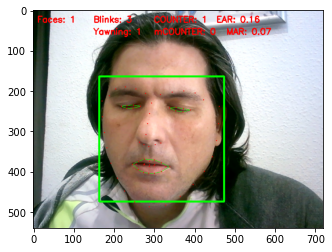

2023-01-06 21:25:58,574 root            INFO     Elapsed time: 4.710328817367554 seconds.
2023-01-06 21:25:58,583 root            INFO     time0:1673040358.5838337
2023-01-06 21:26:00,385 root            INFO     event:INFO,Blinks:3,COUNTER:2,EAR:0.2502998623850305
2023-01-06 21:26:00,396 root            CRITICAL DTYAWN
2023-01-06 21:26:00,408 root            CRITICAL event:INFO,Yawning:1,COUNTER:0,MAR:0.07511983834974671
2023-01-06 21:26:02,368 root            INFO     Evento: DTLIGTH
2023-01-06 21:26:02,384 root            INFO     DTLIGTH
2023-01-06 21:26:02,422 root            INFO     {"clientid": "Client_01", "action": "DTC", "event": "DTLIGTH", "ILight": 6.84661865234375}


24


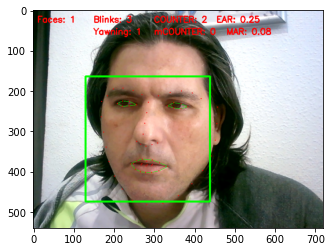

2023-01-06 21:26:03,306 root            INFO     Elapsed time: 4.722027778625488 seconds.
2023-01-06 21:26:03,318 root            INFO     time0:1673040363.3182168
2023-01-06 21:26:04,990 root            INFO     event:INFO,Blinks:3,COUNTER:3,EAR:0.1829891498578076
2023-01-06 21:26:04,998 root            CRITICAL DTYAWN
2023-01-06 21:26:05,004 root            CRITICAL event:INFO,Yawning:1,COUNTER:0,MAR:0.018758282602319768
2023-01-06 21:26:07,448 root            INFO     Evento: DTYAWN
2023-01-06 21:26:07,455 root            INFO     DTYAWN
2023-01-06 21:26:07,470 root            INFO     {"clientid": "Client_01", "action": "DTC", "event": "DTYAWN"}


25


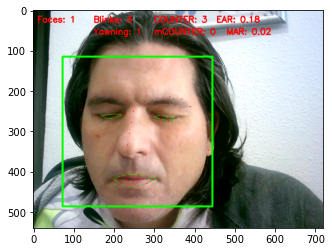

2023-01-06 21:26:07,806 root            INFO     Elapsed time: 4.487825393676758 seconds.
2023-01-06 21:26:07,821 root            INFO     time0:1673040367.8214014
2023-01-06 21:26:09,626 root            INFO     event:INFO,Blinks:3,COUNTER:4,EAR:0.135069104060082
2023-01-06 21:26:09,636 root            CRITICAL DTYAWN
2023-01-06 21:26:09,646 root            CRITICAL event:INFO,Yawning:1,COUNTER:0,MAR:0.1349019971473213


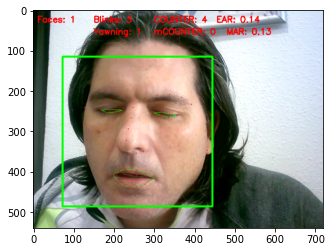

2023-01-06 21:26:12,435 root            INFO     Elapsed time: 4.61360239982605 seconds.
2023-01-06 21:26:12,445 root            INFO     time0:1673040372.445685
2023-01-06 21:26:12,508 root            INFO     Evento: DTYAWN
2023-01-06 21:26:12,517 root            INFO     DTYAWN
2023-01-06 21:26:12,534 root            INFO     {"clientid": "Client_01", "action": "DTC", "event": "DTYAWN"}


26


2023-01-06 21:26:14,140 root            INFO     event:INFO,Blinks:3,COUNTER:5,EAR:0.17336212113339328
2023-01-06 21:26:14,152 root            CRITICAL DTYAWN
2023-01-06 21:26:14,160 root            CRITICAL event:INFO,Yawning:1,COUNTER:0,MAR:0.07733936369874927


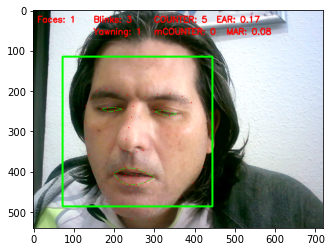

2023-01-06 21:26:17,025 root            INFO     Elapsed time: 4.579268217086792 seconds.
2023-01-06 21:26:17,033 root            INFO     time0:1673040377.0331523
2023-01-06 21:26:17,555 root            INFO     Evento: DTLIGTH
2023-01-06 21:26:17,562 root            INFO     DTLIGTH
2023-01-06 21:26:17,574 root            INFO     {"clientid": "Client_01", "action": "DTC", "event": "DTLIGTH", "ILight": 6.81610107421875}


27


2023-01-06 21:26:18,823 root            INFO     event:INFO,Blinks:3,COUNTER:6,EAR:0.24042210510489986
2023-01-06 21:26:18,834 root            CRITICAL DTYAWN
2023-01-06 21:26:18,843 root            CRITICAL event:INFO,Yawning:1,COUNTER:0,MAR:0.09791341768681622


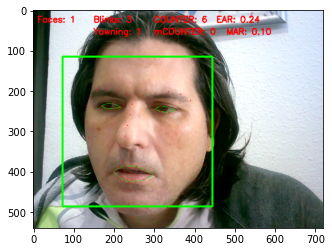

2023-01-06 21:26:21,629 root            INFO     Elapsed time: 4.59601354598999 seconds.
2023-01-06 21:26:21,656 root            INFO     time0:1673040381.6560526
2023-01-06 21:26:22,616 root            INFO     Evento: DTEATING
2023-01-06 21:26:22,623 root            INFO     DTEATING
2023-01-06 21:26:22,641 root            INFO     {"clientid": "Client_01", "action": "DTC", "event": "DTEATING"}


28


2023-01-06 21:26:23,323 root            INFO     event:INFO,Blinks:3,COUNTER:7,EAR:0.2410726960804187
2023-01-06 21:26:23,333 root            CRITICAL DTYAWN
2023-01-06 21:26:23,343 root            CRITICAL event:INFO,Yawning:1,COUNTER:0,MAR:0.07940510210053552


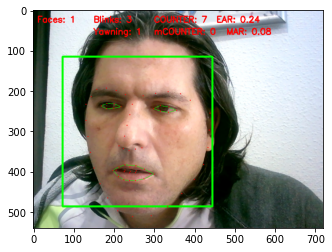

2023-01-06 21:26:26,124 root            INFO     Elapsed time: 4.4685869216918945 seconds.
2023-01-06 21:26:26,140 root            INFO     time0:1673040386.1402686
2023-01-06 21:26:27,671 root            INFO     Evento: DTEATING
2023-01-06 21:26:27,681 root            INFO     DTEATING
2023-01-06 21:26:27,693 root            INFO     {"clientid": "Client_01", "action": "DTC", "event": "DTEATING"}
2023-01-06 21:26:27,801 root            INFO     event:INFO,Blinks:3,COUNTER:8,EAR:0.28779385468469015
2023-01-06 21:26:27,807 root            INFO     event:Yawning,total:3,mtotal:1
2023-01-06 21:26:27,821 root            CRITICAL DTYAWN
2023-01-06 21:26:27,826 root            CRITICAL event:INFO,Yawning:1,COUNTER:1,MAR:0.9926412775705031


29


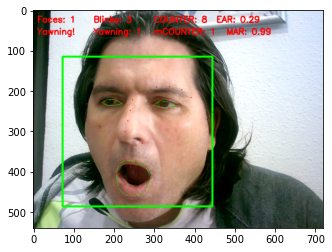

2023-01-06 21:26:30,616 root            INFO     Elapsed time: 4.475640773773193 seconds.
2023-01-06 21:26:30,649 root            INFO     time0:1673040390.6496122
2023-01-06 21:26:32,468 root            INFO     event:INFO,Blinks:3,COUNTER:9,EAR:0.2723952188657942
2023-01-06 21:26:32,476 root            INFO     event:Yawning,total:3,mtotal:1
2023-01-06 21:26:32,484 root            CRITICAL DTYAWN
2023-01-06 21:26:32,494 root            CRITICAL event:INFO,Yawning:1,COUNTER:2,MAR:0.8365076921533093
2023-01-06 21:26:32,743 root            INFO     Evento: DTDRINK
2023-01-06 21:26:32,754 root            INFO     DTDRINK
2023-01-06 21:26:32,771 root            INFO     {"clientid": "Client_01", "action": "DTC", "event": "DTDRINK"}


30


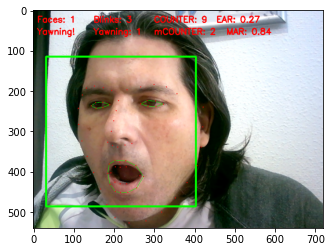

2023-01-06 21:26:35,393 root            INFO     Elapsed time: 4.743915319442749 seconds.
2023-01-06 21:26:35,403 root            INFO     time0:1673040395.4032333
2023-01-06 21:26:37,315 root            INFO     DTBLINK
2023-01-06 21:26:37,320 root            INFO     event:BLINK,total:4,mtotal:1
2023-01-06 21:26:37,336 root            INFO     event:INFO,Blinks:4,COUNTER:0,EAR:0.3007265661102471
2023-01-06 21:26:37,350 root            INFO     event:Yawning,total:4,mtotal:1
2023-01-06 21:26:37,357 root            CRITICAL DTYAWN
2023-01-06 21:26:37,364 root            CRITICAL event:INFO,Yawning:1,COUNTER:3,MAR:0.9171140133609383
2023-01-06 21:26:37,810 root            INFO     Evento: DTEATING
2023-01-06 21:26:37,818 root            INFO     DTEATING
2023-01-06 21:26:37,838 root            INFO     {"clientid": "Client_01", "action": "DTC", "event": "DTEATING"}


31


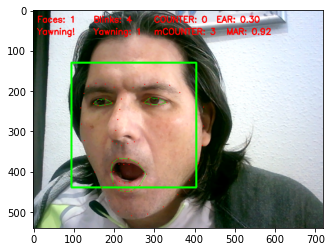

2023-01-06 21:26:40,381 root            INFO     Elapsed time: 4.977859020233154 seconds.
2023-01-06 21:26:40,396 root            INFO     time0:1673040400.3967466
2023-01-06 21:26:42,099 root            INFO     event:INFO,Blinks:4,COUNTER:0,EAR:0.3051352744605579
2023-01-06 21:26:42,105 root            INFO     event:Yawning,total:4,mtotal:1
2023-01-06 21:26:42,114 root            CRITICAL DTYAWN
2023-01-06 21:26:42,120 root            CRITICAL event:INFO,Yawning:1,COUNTER:4,MAR:0.8479802723372292
2023-01-06 21:26:42,869 root            INFO     Evento: DTEATING
2023-01-06 21:26:42,880 root            INFO     DTEATING
2023-01-06 21:26:42,904 root            INFO     {"clientid": "Client_01", "action": "DTC", "event": "DTEATING"}


32


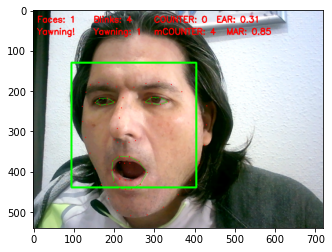

2023-01-06 21:26:44,927 root            INFO     Elapsed time: 4.530559301376343 seconds.
2023-01-06 21:26:44,949 root            INFO     time0:1673040404.948809
2023-01-06 21:26:46,763 root            INFO     event:INFO,Blinks:4,COUNTER:1,EAR:0.29446609166480187
2023-01-06 21:26:46,769 root            CRITICAL event:YAWN,total:4,mtotal:2
2023-01-06 21:26:46,793 root            CRITICAL DTYAWN
2023-01-06 21:26:46,799 root            CRITICAL event:INFO,Yawning:2,COUNTER:0,MAR:0.3900515803597655
2023-01-06 21:26:47,927 root            INFO     Evento: DTYAWN
2023-01-06 21:26:47,938 root            INFO     DTYAWN
2023-01-06 21:26:47,991 root            INFO     {"clientid": "Client_01", "action": "DTC", "event": "DTYAWN"}


33


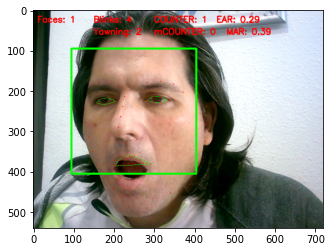

2023-01-06 21:26:49,740 root            INFO     Elapsed time: 4.791386604309082 seconds.
2023-01-06 21:26:49,759 root            INFO     time0:1673040409.758858
2023-01-06 21:26:51,576 root            INFO     event:INFO,Blinks:4,COUNTER:2,EAR:0.2003072249003185
2023-01-06 21:26:51,586 root            CRITICAL DTYAWN
2023-01-06 21:26:51,603 root            CRITICAL event:INFO,Yawning:2,COUNTER:0,MAR:0.023288724957287676
2023-01-06 21:26:53,062 root            INFO     Evento: DTDRINK
2023-01-06 21:26:53,166 root            INFO     DTDRINK
2023-01-06 21:26:53,176 root            INFO     {"clientid": "Client_01", "action": "DTC", "event": "DTDRINK"}


34


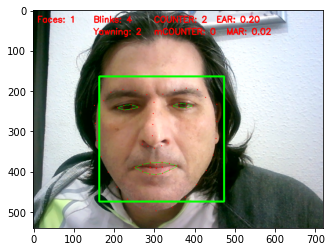

2023-01-06 21:26:54,431 root            INFO     Elapsed time: 4.672051668167114 seconds.
2023-01-06 21:26:54,444 root            INFO     time0:1673040414.4442348
2023-01-06 21:26:56,233 root            INFO     event:INFO,Blinks:4,COUNTER:3,EAR:0.2960221607879724
2023-01-06 21:26:56,245 root            CRITICAL DTYAWN
2023-01-06 21:26:56,256 root            CRITICAL event:INFO,Yawning:2,COUNTER:0,MAR:0.048105563218946844
2023-01-06 21:26:58,243 root            INFO     Evento: DTLIGTH
2023-01-06 21:26:58,271 root            INFO     DTLIGTH
2023-01-06 21:26:58,285 root            INFO     {"clientid": "Client_01", "action": "DTC", "event": "DTLIGTH", "ILight": 6.89544677734375}


35


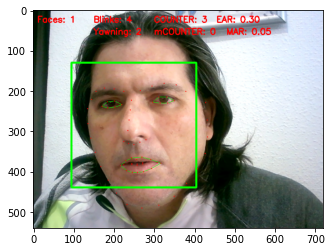

2023-01-06 21:26:59,094 root            INFO     Elapsed time: 4.64995265007019 seconds.
2023-01-06 21:26:59,114 root            INFO     time0:1673040419.114174
2023-01-06 21:27:00,789 root            INFO     event:INFO,Blinks:4,COUNTER:4,EAR:0.28659633389748196
2023-01-06 21:27:00,798 root            CRITICAL DTYAWN
2023-01-06 21:27:00,804 root            CRITICAL event:INFO,Yawning:2,COUNTER:0,MAR:0.10023574810195816
2023-01-06 21:27:03,358 root            INFO     Evento: DTDRINK
2023-01-06 21:27:03,509 root            INFO     DTDRINK


36


2023-01-06 21:27:03,573 root            INFO     {"clientid": "Client_01", "action": "DTC", "event": "DTDRINK"}


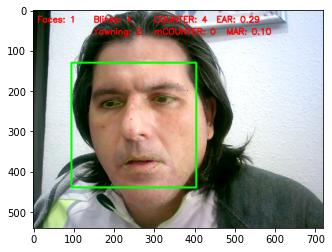

2023-01-06 21:27:05,022 root            INFO     Elapsed time: 5.9078967571258545 seconds.
2023-01-06 21:27:05,040 root            INFO     time0:1673040425.0402725
2023-01-06 21:27:06,832 root            INFO     event:INFO,Blinks:4,COUNTER:5,EAR:0.24425882345232466
2023-01-06 21:27:06,847 root            CRITICAL DTYAWN
2023-01-06 21:27:06,864 root            CRITICAL event:INFO,Yawning:2,COUNTER:0,MAR:0.09336477764488371
2023-01-06 21:27:08,699 root            INFO     Evento: DTSMOKING
2023-01-06 21:27:08,706 root            INFO     DTSMOKING
2023-01-06 21:27:08,728 root            INFO     {"clientid": "Client_01", "action": "DTC", "event": "DTSMOKING"}


37


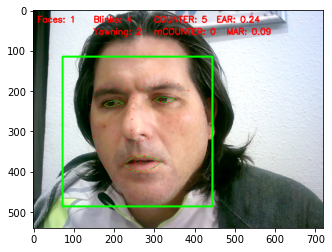

2023-01-06 21:27:09,651 root            INFO     Elapsed time: 4.610868692398071 seconds.
2023-01-06 21:27:09,664 root            INFO     time0:1673040429.6639817
2023-01-06 21:27:11,329 root            INFO     event:INFO,Blinks:4,COUNTER:6,EAR:0.26403373964246624
2023-01-06 21:27:11,338 root            CRITICAL DTYAWN
2023-01-06 21:27:11,350 root            CRITICAL event:INFO,Yawning:2,COUNTER:0,MAR:0.09003903422516485
2023-01-06 21:27:13,756 root            INFO     Evento: DTTEMP
2023-01-06 21:27:13,767 root            INFO     DTTEMP
2023-01-06 21:27:13,786 root            INFO     {"clientid": "Client_01", "action": "DTC", "event": "DTTEMP", "Temp": -7.575218200683594}


38


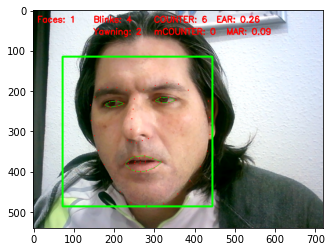

2023-01-06 21:27:14,152 root            INFO     Elapsed time: 4.488138675689697 seconds.
2023-01-06 21:27:14,163 root            INFO     time0:1673040434.1637068
2023-01-06 21:27:15,949 root            INFO     event:INFO,Blinks:4,COUNTER:7,EAR:0.25792373091555126
2023-01-06 21:27:15,959 root            CRITICAL DTYAWN
2023-01-06 21:27:15,966 root            CRITICAL event:INFO,Yawning:2,COUNTER:0,MAR:0.08291059630075519
2023-01-06 21:27:18,814 root            INFO     Evento: DTTEMP


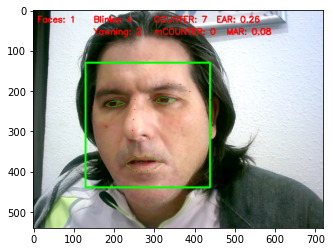

2023-01-06 21:27:18,820 root            INFO     DTTEMP
2023-01-06 21:27:18,828 root            INFO     Elapsed time: 4.6644651889801025 seconds.
2023-01-06 21:27:18,849 root            INFO     {"clientid": "Client_01", "action": "DTC", "event": "DTTEMP", "Temp": -7.581459045410156}
2023-01-06 21:27:18,857 root            INFO     time0:1673040438.8572245


39


2023-01-06 21:27:20,670 root            INFO     event:INFO,Blinks:4,COUNTER:8,EAR:0.2634014098686288
2023-01-06 21:27:20,681 root            CRITICAL DTYAWN
2023-01-06 21:27:20,689 root            CRITICAL event:INFO,Yawning:2,COUNTER:0,MAR:0.026020269542287682


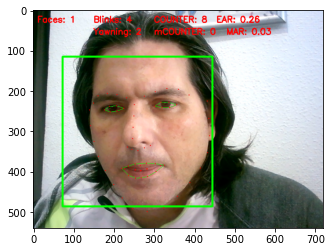

2023-01-06 21:27:23,473 root            INFO     Elapsed time: 4.615931749343872 seconds.
2023-01-06 21:27:23,491 root            INFO     time0:1673040443.4910421
2023-01-06 21:27:23,877 root            INFO     Evento: DTLIGTH
2023-01-06 21:27:23,887 root            INFO     DTLIGTH
2023-01-06 21:27:23,895 root            INFO     {"clientid": "Client_01", "action": "DTC", "event": "DTLIGTH", "ILight": 6.8695068359375}


40


2023-01-06 21:27:25,222 root            INFO     event:INFO,Blinks:4,COUNTER:9,EAR:0.2739985816284237
2023-01-06 21:27:25,233 root            CRITICAL DTYAWN
2023-01-06 21:27:25,246 root            CRITICAL event:INFO,Yawning:2,COUNTER:0,MAR:0.056848278597021934


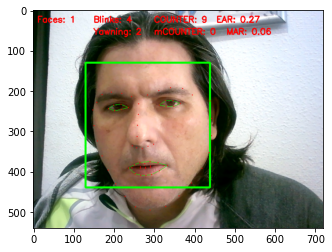

2023-01-06 21:27:28,105 root            INFO     Elapsed time: 4.614198923110962 seconds.
2023-01-06 21:27:28,114 root            INFO     time0:1673040448.114187
2023-01-06 21:27:28,914 root            INFO     Evento: DTLIGTH
2023-01-06 21:27:28,921 root            INFO     DTLIGTH
2023-01-06 21:27:28,943 root            INFO     {"clientid": "Client_01", "action": "DTC", "event": "DTLIGTH", "ILight": 6.8328857421875}


41


2023-01-06 21:27:29,839 root            INFO     event:INFO,Blinks:4,COUNTER:10,EAR:0.2804740149627333
2023-01-06 21:27:29,849 root            CRITICAL DTYAWN
2023-01-06 21:27:29,856 root            CRITICAL event:INFO,Yawning:2,COUNTER:0,MAR:0.037357264406104235


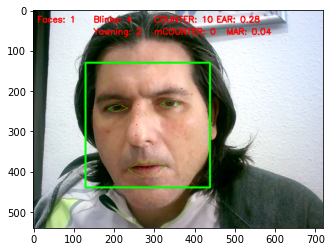

2023-01-06 21:27:32,644 root            INFO     Elapsed time: 4.53035831451416 seconds.
2023-01-06 21:27:32,658 root            INFO     time0:1673040452.6582246
2023-01-06 21:27:33,978 root            INFO     Evento: DTEATING
2023-01-06 21:27:33,985 root            INFO     DTEATING
2023-01-06 21:27:33,998 root            INFO     {"clientid": "Client_01", "action": "DTC", "event": "DTEATING"}


42


2023-01-06 21:27:34,316 root            INFO     event:INFO,Blinks:4,COUNTER:11,EAR:0.2570934798496919
2023-01-06 21:27:34,327 root            CRITICAL DTYAWN
2023-01-06 21:27:34,337 root            CRITICAL event:INFO,Yawning:2,COUNTER:0,MAR:0.03676384398713375


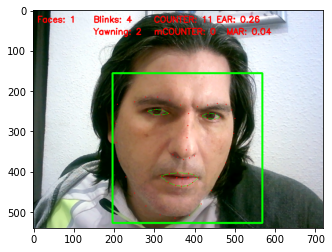

2023-01-06 21:27:37,198 root            INFO     Elapsed time: 4.540008068084717 seconds.
2023-01-06 21:27:37,215 root            INFO     time0:1673040457.2147663
2023-01-06 21:27:39,105 root            INFO     event:INFO,Blinks:4,COUNTER:12,EAR:0.289049383566382
2023-01-06 21:27:39,184 root            CRITICAL DTYAWN
2023-01-06 21:27:39,285 root            CRITICAL event:INFO,Yawning:2,COUNTER:0,MAR:0.07113756836734014


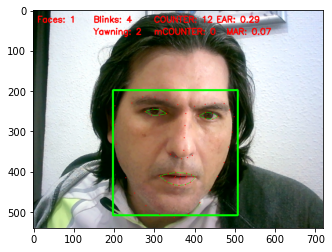

2023-01-06 21:27:46,571 root            INFO     Elapsed time: 9.356741189956665 seconds.
2023-01-06 21:27:46,608 root            INFO     time0:1673040466.6086965
2023-01-06 21:27:48,562 root            INFO     event:INFO,Blinks:4,COUNTER:13,EAR:0.27362907971360895


KeyboardInterrupt: 

2023-01-06 21:27:48,613 root            CRITICAL DTYAWN


In [20]:
init_app_con_somnolencia ()  # Con detección somnolencia con la pynq

## 6.3 Cerrar la app

In [ ]:
 close_app ()

2023-01-06 21:27:48,626 root            CRITICAL event:INFO,Yawning:2,COUNTER:0,MAR:0.058069350407296334
